In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
# from tensorflow.keras.applications.vgg16 import VGG16


In [2]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TF Version: 2.12.0
Num GPUs Available: 0


In [4]:
# import kagglehub

# # Download latest version of dataset
# path = kagglehub.dataset_download("michaeljkerr/20k-album-covers-within-20-genres")

# print("Path to dataset files:", path)

In [3]:
import pandas as pd
import os

genres = ['Blues', 'Classical', 'Country', 'DeathMetal', 'DoomMetal', 'DrumNBass', 'Electronic', 'Folk', 'Grime', 'HeavyMetal', 'HipHop', 'Jazz', 'LoFi', 'Pop', 'PsychedelicRock', 'Punk', 'Reggae', 'Rock', 'Soul', 'Techno']

# Produce one-hot encoding values

genres_dict = {index: genres[index] for index in range(20)}
print(genres_dict)

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'DeathMetal', 4: 'DoomMetal', 5: 'DrumNBass', 6: 'Electronic', 7: 'Folk', 8: 'Grime', 9: 'HeavyMetal', 10: 'HipHop', 11: 'Jazz', 12: 'LoFi', 13: 'Pop', 14: 'PsychedelicRock', 15: 'Punk', 16: 'Reggae', 17: 'Rock', 18: 'Soul', 19: 'Techno'}


In [4]:
# Downsize image size from 300x300 to 224x224 for use in VGG16 model

from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# from sklearn.model_selection import train_test_split
# stratify target

data_dir = 'GAID'

img_height = 200
img_width = 200
batch_size = 32

train_ds = image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.20,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.20,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 20000 files belonging to 20 classes.
Using 16000 files for training.
Found 20000 files belonging to 20 classes.
Using 4000 files for validation.


In [5]:
# Looping over the training data to extract values from the data-generators into numpy arrays
train_ds_x = []
train_ds_y = []
for images, labels in train_ds.take(-1):
  train_ds_x.append( images.numpy() )
  train_ds_y.append( labels.numpy() )


# Looping over the validation data to extract values from the data-generators into numpy arrays
val_ds_x = []
val_ds_y = []
for images, labels in val_ds.take(-1):
  val_ds_x.append( images.numpy() )
  val_ds_y.append( labels.numpy() )

train_ds_x = np.concatenate(train_ds_x)
val_ds_x = np.concatenate(val_ds_x)
y_train = np.concatenate(train_ds_y)
y_val = np.concatenate(val_ds_y)

2024-11-26 11:54:26.614937: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
x_train = train_ds_x/255
x_val = val_ds_x/255

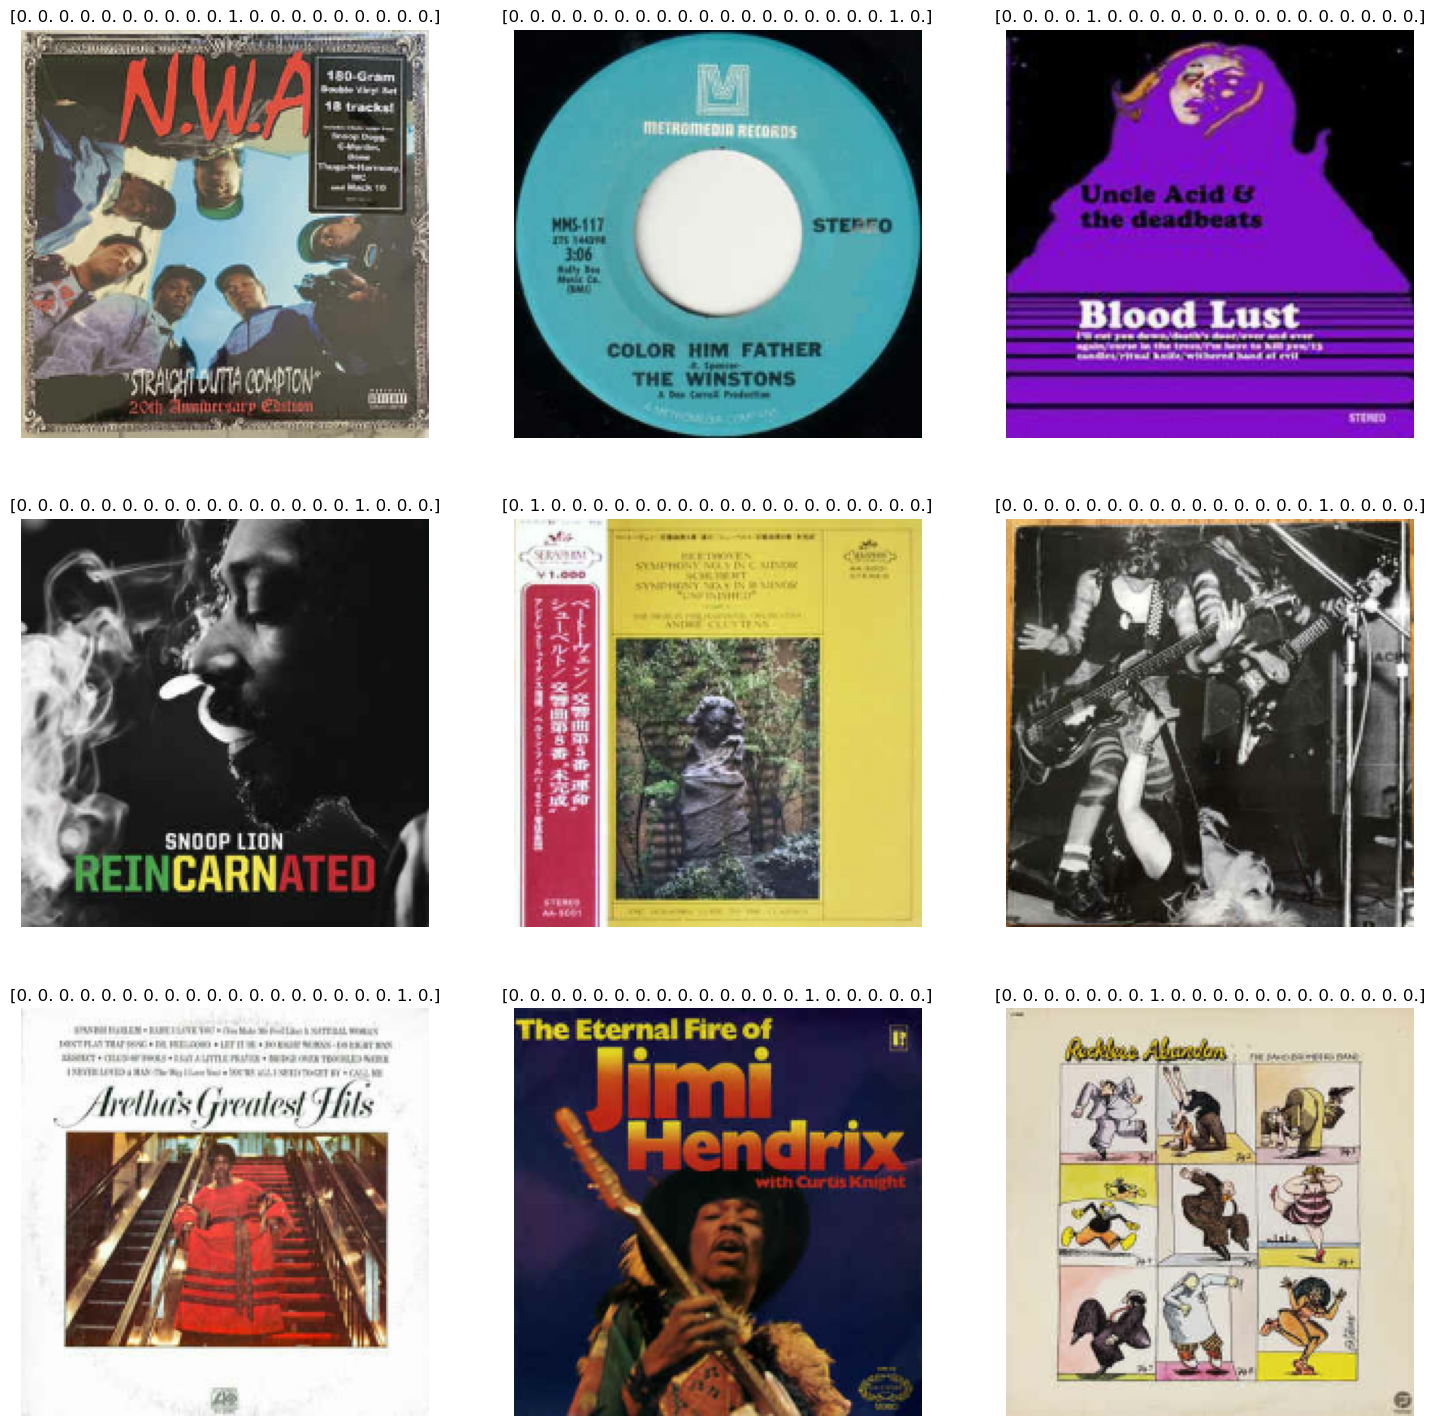

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i])
  plt.title(str( y_train[i]))
  plt.axis("off")

In [9]:
# from keras.applications.densenet import preprocess_input
# from keras.applications.densenet import DenseNet121
# from keras.models import Model
# from keras.layers import Dense
# from keras.metrics import Precision, Recall, AUC

# x_train = preprocess_input(train_ds_x)
# x_val = preprocess_input(val_ds_x)

# # Load DenseNet model
# model = DenseNet121(include_top=False, input_shape=(200, 200, 3), pooling='max')

# # Add a dense layer for classification with 20 outputs and sigmoid activation
# output = Dense(20, activation='softmax')(model.output)

# # Freeze base model layers to use it as a feature extractor
# for layer in model.layers:
#     layer.trainable = False

# # Create the final model
# final_model = Model(inputs=model.inputs, outputs=output)

# # Compile the model
# final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall(), AUC()])

# # Train the model
# final_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

# # Evaluate the model
# score = final_model.evaluate(x_val, y_val)

In [10]:
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense
from keras.metrics import Precision, Recall, AUC

# x_train = preprocess_input(train_ds_x)
# x_val = preprocess_input(val_ds_x)

model = DenseNet121(include_top=False, input_shape=(200, 200, 3), pooling='max')

output = Dense(20, activation='softmax')(model.output)

for layer in model.layers[-16:]:
    layer.trainable = True

final_model = Model(inputs=model.inputs, outputs=output)

final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall(), AUC()])

final_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val), workers=4, use_multiprocessing=True)

score = final_model.evaluate(x_val, y_val)

Epoch 1/5
125/125 [==============================] - 1402s 11s/step - loss: 3.4975 - accuracy: 0.1275 - precision: 0.1794 - recall: 0.0296 - auc: 0.6272 - val_loss: 4.1173 - val_accuracy: 0.1002 - val_precision: 0.1975 - val_recall: 0.0520 - val_auc: 0.5948
Epoch 2/5
125/125 [==============================] - 1422s 11s/step - loss: 2.6228 - accuracy: 0.2174 - precision: 0.5377 - recall: 0.0423 - auc: 0.7496 - val_loss: 2.8297 - val_accuracy: 0.1803 - val_precision: 0.5483 - val_recall: 0.0483 - val_auc: 0.7110
Epoch 3/5
125/125 [==============================] - 1369s 11s/step - loss: 2.4102 - accuracy: 0.2777 - precision: 0.6086 - recall: 0.0741 - auc: 0.8004 - val_loss: 2.6344 - val_accuracy: 0.2218 - val_precision: 0.5675 - val_recall: 0.0715 - val_auc: 0.7515
Epoch 4/5
125/125 [==============================] - 1370s 11s/step - loss: 2.3229 - accuracy: 0.3069 - precision: 0.6230 - recall: 0.1037 - auc: 0.8229 - val_loss: 3.2063 - val_accuracy: 0.1663 - val_precision: 0.2529 - val_r

In [11]:
final_model.save('saved_models/DenseNet_v1.keras')

In [22]:
!pip install tf_keras_vis tensorflow

python(60410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached tf_keras_vis-0.8.7-py3-none-any.whl.metadata (10 kB)
  Using cached Deprecated-1.2.15-py2.py3-none-any.whl.metadata (5.5 kB)
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached jaxlib-0.4.35-cp311-cp311-macosx_11_0_arm64.whl.metadata (983 bytes)
  Using cached ml_dtypes-0.5.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.4.34-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.34-cp311-cp311-macosx_11_0_arm64.whl.metadata (983 bytes)
  Using cached jax-0.4.33-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.33-cp311-cp311-macosx_11_0_arm64.whl.metadata (983 bytes)
  Using cached jax-0.4.31-py3-none-any.whl.metadat

In [6]:
final_model = tf.keras.models.load_model('saved_models/DenseNet_v1.keras')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Ensure input data is normalized and compatible with the model
x_train = train_ds_x / 255  # Normalize if needed
class_index = 0  # Replace with the target class index for visualization

# Define the score function for saliency
temp_score = CategoricalScore([class_index])

# Create the model modifier
replace2linear = ReplaceToLinear()

# Create the Saliency object
saliency = Saliency(final_model, model_modifier=replace2linear, clone=False)

# Generate saliency map
saliency_map = saliency(temp_score, x_train)

# Reduce saliency map to 2D for visualization
saliency_map = np.max(saliency_map[0], axis=-1)  # Collapse color channels

# Render saliency map
plt.imshow(saliency_map, cmap='jet')
plt.colorbar()  # Optional: Adds a colorbar for the heatmap
plt.axis('off')
plt.title("Saliency Map")
plt.show()

: 

In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


In [9]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [10]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
temp_score = CategoricalScore([0])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1])

In [11]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(final_model,
                    model_modifier=replace2linear,
                    clone=False)

# Generate saliency map
saliency_map = saliency(temp_score, x_train)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
plt.imshow(saliency_map[0], cmap='jet')

# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
# ax[0].imshow(saliency_map[0], cmap='jet')
# ax[0].axis('off')
# # for i, title in enumerate():
# #     ax[i].set_title(title, fontsize=16)
# #     ax[i].imshow(saliency_map[i], cmap='jet')
# #     ax[i].axis('off')
# plt.tight_layout()
# plt.show()

# layer_idx = utils.find_layer_idx(final_model, final_model.layers[-1].name)
# final_model.layers[-1].activation = tf.keras.activations.linear
# final_model = utils.apply_modifications(final_model)

# # saliency = Saliency(final_model, clone=False)

# grads = visualize_saliency(final_model, layer_idx, filter_indices=None, seed_input=42)
# plt.imshow(grads, cmap='jet')

: 

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# from vis.visualization import visualize_saliency
# from vis.utils import utils
# from tensorflow.keras import activations

from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize
# from tf_keras_vis.utils.scores import CategoricalScore
# from vis.utils import utils
# import tensorflow as tf

# Define genres and map them to class indices
genres = [
    'Blues', 'Classical', 'Country', 'DeathMetal', 'DoomMetal', 'DrumNBass', 'Electronic',
    'Folk', 'Grime', 'HeavyMetal', 'HipHop', 'Jazz', 'LoFi', 'Pop', 'PsychedelicRock',
    'Punk', 'Reggae', 'Rock', 'Soul', 'Techno'
]
genres_dict = {genre: index for index, genre in enumerate(genres)}

parent_dir = 'GAID'

genre_results = {}

layer_idx = utils.find_layer_idx(final_model, final_model.layers[-1].name)
final_model.layers[-1].activation = tf.keras.activations.linear
final_model = utils.apply_modifications(final_model)

# saliency = Saliency(final_model, clone=False)

grads = visualize_saliency(final_model, layer_idx, filter_indices=None, seed_input=42)
plt.imshow(grads, cmap='jet')

# # Process each genre and generate saliency map
# for genre in os.listdir(parent_dir):
#     genre_path = os.path.join(parent_dir, genre)
#     if os.path.isdir(genre_path):
#         files = sorted(os.listdir(genre_path))
#         if files:
#             first_file = files[0]
#             file_path = os.path.join(genre_path, first_file)

#             img = load_img(file_path, target_size=(200, 200))
#             img_array = img_to_array(img)
#             x = np.expand_dims(img_array, axis=0)

#             # Define the score for the saliency map
#             # Assuming class index corresponds to the genre, adjust as necessary
#             class_index = 0  # Adjust based on your class mapping
#             score = CategoricalScore([class_index])

#             # Map the genre to its class index
#             class_index = genres_dict[genre]

#             # Define the score for the saliency map
#             score = CategoricalScore([class_index])

#             # Generate saliency map
#             saliency_map = saliency(score, x, smooth_samples=20, smooth_noise=0.2)
#             saliency_map = normalize(saliency_map)

#             # Save original image and saliency map
#             genre_results[genre] = (img, saliency_map[0])

#             print(f"Generated saliency map for {first_file} in {genre} genre.")

# fig, axes = plt.subplots(len(genre_results), 2, figsize=(10, 5 * len(genre_results)))

# for i, (genre, (img, saliency_map)) in enumerate(genre_results.items()):
#     # Original image
#     axes[i, 0].imshow(img.astype("uint8"))
#     axes[i, 0].set_title(f"{genre} - Original")
#     axes[i, 0].axis("off")

#     # Saliency map
#     axes[i, 1].imshow(saliency_map, cmap='jet')
#     axes[i, 1].set_title(f"{genre} - Saliency Map")
#     axes[i, 1].axis("off")

# plt.tight_layout()
# plt.show()


ModuleNotFoundError: No module named 'vis'

In [13]:
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Precision: {score[2]}")
print(f"Recall: {score[3]}")
print(f"AUC: {score[4]}")

Loss: 3.561007261276245
Accuracy: 0.12700000405311584
Precision: 0.27892234921455383
Recall: 0.04399999976158142
AUC: 0.6357245445251465


In [13]:
model = DenseNet121(include_top=False, input_shape=(200, 200, 3), pooling='max')

output = Dense(20, activation='softmax')(model.output)

for layer in model.layers[-16:]:
    layer.trainable = True

final_model = Model(inputs=model.inputs, outputs=output)

final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall(), AUC()])

final_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

score = final_model.evaluate(x_val, y_val)

Epoch 1/5
  4/110 [>.............................] - ETA: 18:25 - loss: 6.2992 - accuracy: 0.0742 - precision_1: 0.0831 - recall_1: 0.0566 - auc_1: 0.5488

KeyboardInterrupt: 

In [10]:
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Precision: {score[2]}")
print(f"Recall: {score[3]}")
print(f"AUC: {score[4]}")

Loss: 3.0610969066619873
Accuracy: 0.18816666305065155
Precision: 0.32578524947166443
Recall: 0.07433333247900009
AUC: 0.7059805393218994


In [18]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

x_train = preprocess_input(train_ds_x)
x_val = preprocess_input(val_ds_x)

model = VGG16(include_top=False, input_shape=(200, 200, 3), pooling='max')

output = Dense(20, activation='sigmoid')(model.output)

for layer in model.layers:
    layer.trainable = False

final_model = Model(inputs=model.inputs, outputs=output)

final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

final_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

score = final_model.evaluate(x_val, y_val)
print(score)

Epoch 1/5
  2/110 [..............................] - ETA: 10:40 - loss: 0.8769 - accuracy: 0.0430

KeyboardInterrupt: 

Saliency maps -> which pixels are most important
- Look at specific images that the model got very wrong or very right

distill.pub
- Visual guide for NNs
- Optimize an image s.t. it was a 'perfect' image for a given genre